# Create new library designer function

Import data.

In [2]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [3]:
building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

align fingerprints
partition building blocks


Create inputs to the DrugEnv.

In [4]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

Testing the best performing molecule from docking screen.

In [5]:
mol = dg.molecule.Molecule(
    'Cc1ccccc1C(=O)Nc1nc(-c2cccc(O)c2)cs1',
    reactants = [
        dg.molecule.Molecule('Cc1ccccc1C(=O)O'),
        dg.molecule.Molecule('Nc1nc(-c2cccc(O)c2)cs1'),
    ]
)

analogs = library_designer.design(
    molecules = [mol],
    num_analogs = 20,
    fraction_random = 0.0
)

In [6]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create molecular properties
# log_P_oracle = RDKitOracle('MolLogP')
# log_S_oracle = DGLOracle('GCN_canonical_ESOL')

# create docking oracle
config = {
    'center_x': 9.812,
    'center_y': -0.257,
    'center_z': 20.8485,
    'size_x': 14.328,
    'size_y': 8.85,
    'size_z': 12.539,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'scoring': 'vinardo',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'Mpro affinity',
    receptor_path=f'{path}/Mpro_prepped.pdbqt',
    config=config
)

# create evaluators
# log_S_evaluator = ClassicEvaluator(ideal=(-2, 0), acceptable=(-4, 0.5))
# log_P_evaluator = ClassicEvaluator(ideal=(1, 4), acceptable=(0, 5))
# docking_evaluator = ClassicEvaluator(ideal=(-12, -9), acceptable=(-12, -7))
docking_evaluator = ClassicEvaluator(ideal=(9, 12), acceptable=(7, 12))

# create utility function
utility_function = UtilityFunction(
    oracles = [
        docking_oracle,
        # log_S_oracle,
        # log_P_oracle
    ],
    evaluators = [
        docking_evaluator,
        # log_S_evaluator,
        # log_P_evaluator
    ],
    strategy = lambda x: np.prod(x, axis=0)
)

# utility = utility_function(deck)
# best_molecules = utility.argsort().tolist()[-25:]

In [7]:
results = docking_oracle(analogs)

In [12]:
# chemfp.simsearch??

In [14]:
library_designer.fingerprints.metadata

Metadata(num_bits=1024, num_bytes=128, type='OpenBabel-ECFP4/1 nBits=1024', aromaticity=None, sources=['./Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf'], software='OpenBabel/3.1.0 chemfp/4.1', date='2023-07-26T07:13:20')

In [19]:
%%time

import chemfp
from rdkit import Chem

indices = chemfp.simsearch(
    k = 10,
    query = deck.smiles[0],
    targets = library_designer.fingerprints
)

CPU times: user 4.9 ms, sys: 235 µs, total: 5.14 ms
Wall time: 5.05 ms


In [210]:
from tqdm.notebook import tqdm

coll = []
for bb in tqdm(bbs):
    if bb:
        coll.append(dg.molecule.Molecule(bb))
    else:
        coll.append(dg.molecule.Molecule(''))
coll = dg.collection.MoleculeCollection(coll)

  0%|          | 0/262336 [00:00<?, ?it/s]

In [260]:
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import paired_distances
import numpy as np

def calculate_paired_jaccard_distances(X, Y):
    """
    Calculate the pairwise Jaccard distances between two sets of binary vectors.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        First set of binary vectors.
    Y : array-like of shape (n_samples, n_features)
        Second set of binary vectors. Must have the same number of samples as X.

    Returns
    -------
    distances : ndarray of shape (n_samples,)
        Array containing the pairwise Jaccard distances.

    Examples
    --------
    >>> X = np.array([[1, 0, 1], [1, 1, 0], [0, 1, 0]])
    >>> Y = np.array([[0, 1, 1], [1, 1, 1], [1, 0, 0]])
    >>> calculate_paired_jaccard_distances(X, Y)
    array([0.66666667, 0.33333333, 1.        ])
    """
    # Define a function to calculate the Jaccard distance
    def jaccard_distance(u, v):
        # Jaccard distance is 1 minus the Jaccard similarity
        return 1 - jaccard_score(u, v)

    # Calculate the pairwise distances using the custom metric
    return paired_distances(X, Y, metric=jaccard_distance)

# Example usage
X = np.array([[1, 0, 1]]*3)
Y = np.array([[0, 1, 1], [1, 1, 1], [1, 0, 0]])
calculate_paired_jaccard_distances(X, Y)

array([0.66666667, 0.33333333, 0.5       ])

In [261]:
X

array([[1, 0, 1],
       [1, 0, 1],
       [1, 0, 1]])

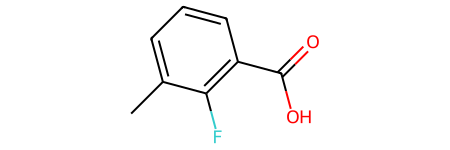

In [253]:
analogs[0].reactants[1]

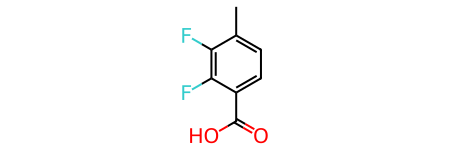

In [254]:
coll[indices[1]]

In [228]:
prod = coll[indices[0]]
for reaction in reactions:
    if any(prod.mol.HasSubstructMatch(reactant)
           for reactant in reaction.reactants):
        print(prod.smiles, reaction.id)

Cc1cccc(C(=O)O)c1F 13_Carboxylate_and_Amine
Cc1cccc(C(=O)O)c1F 14_Carboxylate_and_Alcohol
Cc1cccc(C(=O)O)c1F 15_Carboxylate_and_Thiol
Cc1cccc(C(=O)O)c1F 16_Carboxylate_To_Cyanide
Cc1cccc(C(=O)O)c1F 17_Carboxylate_To_Azide
Cc1cccc(C(=O)O)c1F 38_benzimidazole_derivatives_carboxylic_acid_ester
Cc1cccc(C(=O)O)c1F 42_benzoxazole_carboxylic_acid
Cc1cccc(C(=O)O)c1F 52_1_2_4_triazole_carboxylic_acid_ester
Cc1cccc(C(=O)O)c1F 64_oxadiazole
Cc1cccc(C(=O)O)c1F 83_Schotten_Baumann_amide
